In [1]:
include("../../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [2]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack, JLD2, OrdinaryDiffEq
using Plots;

In [3]:
JLD2.@load("Ocean_geostrophic_velocity.jld2");
UV = interpolateVF(Lon, Lat, Time, UT, VT);

In [4]:
# Parameters
grid_resolution        = 200
quadrature_order       = 5
nevs                   = 6
ϵ                      = 0.001
num_steps              = 200
t_initial              = minimum(Time)
t_end                  = t_initial+70     # parameter value corresponding to ϵ=0 (t_max is 90)
wind_scale             = 1e-5
wind_center            = 30;
solver_tolerance       = 1e-8
solver                 = OrdinaryDiffEq.BS5();

In [5]:
lattitude_range = range(minimum(Lat),maximum(Lat),length=size(UT)[2]) # should be equal to Lat, but just to be safe
wind_u = repeat(collect(wind_scale.*(lattitude_range.-wind_center))',size(UT)[1],1,size(UT)[3])
wind_v = zero(VT); #no northward component of wind
wind = interpolateVF(Lon, Lat, Time, wind_u, wind_v);

In [6]:
# it would be much easier to write this with interp_rhs and p=UV .+ param.*wind, but that has the wrong type
interp_rhs_scaled = OrdinaryDiffEq.ODEFunction{false}((u,p,t) -> p[1](u[1],u[2],t) .+ p[3].*p[2](u[1],u[2],t))
function T(x,param)
    flow(interp_rhs_scaled, x, [t_initial, t_end]; 
        p=(UV, wind, param), tolerance=solver_tolerance, solver=solver)[end]
end

T (generic function with 1 method)

In [7]:
LL, UR = (-4.0, -34.0), (6.0, -28.0)
lon_resolution = grid_resolution
lat_resolution = Integer(floor((UR[2] - LL[2])/(UR[1] - LL[1])*grid_resolution))
ctx, _ = regularTriangularGrid((lon_resolution, lat_resolution), 
        LL, UR, quadrature_order = quadrature_order);
bdata = getHomDBCS(ctx, "all");

In [8]:
M = assembleMassMatrix(ctx, bdata=bdata);

In [9]:
# assemble K
DT₀(x) = linearized_flow_autodiff(y -> T(y,0) , x)
A₀(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DT₀(x))))
@time K = assembleStiffnessMatrix(ctx, A₀, bdata=bdata)
nothing

176.638994 seconds (95.48 M allocations: 5.413 GiB, 0.80% gc time)


In [10]:
evs = zeros(num_steps+1,nevs)
evs[Int(num_steps/2 +1),:] , _ = eigs(K, M, nev=nevs, which=:SM);

In [11]:
for i in 1:(num_steps/2)
    DTϵ(x) = linearized_flow_autodiff(y -> T(y,i*ϵ) , x)
    Aϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTϵ(x))))
    @time Kϵ = assembleStiffnessMatrix(ctx, Aϵ, bdata=bdata)
    DTminusϵ(x) = linearized_flow_autodiff(y -> T(y,-i*ϵ) , x)
    Aminusϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTminusϵ(x))))
    @time Kminusϵ = assembleStiffnessMatrix(ctx, Aminusϵ, bdata=bdata)
    evs[Int(num_steps/2 +1+i),:], _ = eigs(Kϵ, M, nev=nevs, which=:SM)
    evs[Int(num_steps/2 +1-i),:], _ = eigs(Kminusϵ, M, nev=nevs, which=:SM)
    print(Int(i), "/" ,Int(num_steps/2), "\n")
end
nothing

164.553925 seconds (59.38 M allocations: 3.276 GiB, 0.31% gc time)
162.994833 seconds (59.18 M allocations: 3.265 GiB, 0.31% gc time)
1/100
161.133584 seconds (45.28 M allocations: 2.663 GiB, 0.20% gc time)
161.157428 seconds (45.28 M allocations: 2.663 GiB, 0.21% gc time)
2/100
162.021441 seconds (45.28 M allocations: 2.663 GiB, 0.42% gc time)
160.768844 seconds (45.28 M allocations: 2.663 GiB, 0.18% gc time)
3/100
161.724792 seconds (45.28 M allocations: 2.663 GiB, 0.17% gc time)
160.729541 seconds (45.28 M allocations: 2.663 GiB, 0.17% gc time)
4/100
161.539569 seconds (45.28 M allocations: 2.663 GiB, 0.17% gc time)
160.631608 seconds (45.28 M allocations: 2.663 GiB, 0.18% gc time)
5/100
162.157524 seconds (45.28 M allocations: 2.663 GiB, 0.17% gc time)
161.328527 seconds (45.28 M allocations: 2.663 GiB, 0.18% gc time)
6/100
163.323644 seconds (45.28 M allocations: 2.663 GiB, 0.17% gc time)
163.648549 seconds (45.28 M allocations: 2.663 GiB, 0.19% gc time)
7/100
163.397607 seconds (

159.327236 seconds (45.28 M allocations: 2.663 GiB, 0.17% gc time)
59/100
160.016413 seconds (45.28 M allocations: 2.663 GiB, 0.17% gc time)
159.418507 seconds (45.28 M allocations: 2.663 GiB, 0.18% gc time)
60/100
159.714558 seconds (45.28 M allocations: 2.663 GiB, 0.17% gc time)
160.946613 seconds (45.28 M allocations: 2.663 GiB, 0.17% gc time)
61/100
162.538771 seconds (45.28 M allocations: 2.663 GiB, 0.17% gc time)
160.286689 seconds (45.28 M allocations: 2.663 GiB, 0.18% gc time)
62/100
159.593139 seconds (45.28 M allocations: 2.663 GiB, 0.17% gc time)
158.408171 seconds (45.28 M allocations: 2.663 GiB, 0.17% gc time)
63/100
159.425321 seconds (45.28 M allocations: 2.663 GiB, 0.17% gc time)
158.817892 seconds (45.28 M allocations: 2.663 GiB, 0.17% gc time)
64/100
160.468091 seconds (45.28 M allocations: 2.663 GiB, 0.17% gc time)
161.405772 seconds (45.28 M allocations: 2.663 GiB, 0.17% gc time)
65/100
162.601055 seconds (45.28 M allocations: 2.663 GiB, 0.17% gc time)
160.899885 se

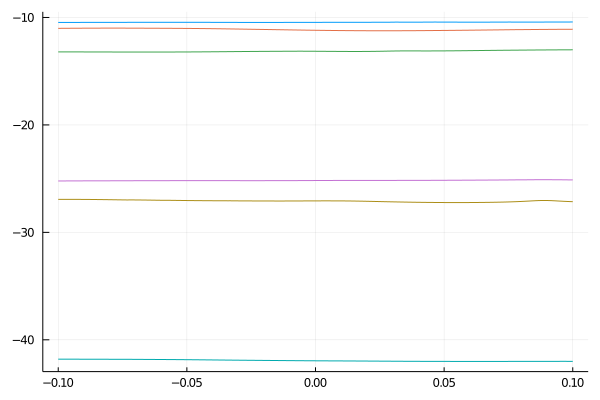

In [12]:
Plots.plot(range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1), evs, legend=false, fmt = :png)

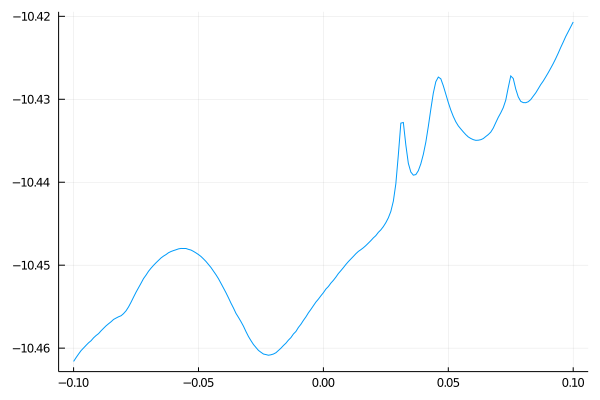

In [13]:
Plots.plot(range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1), evs[:,1], legend=false, fmt = :png)

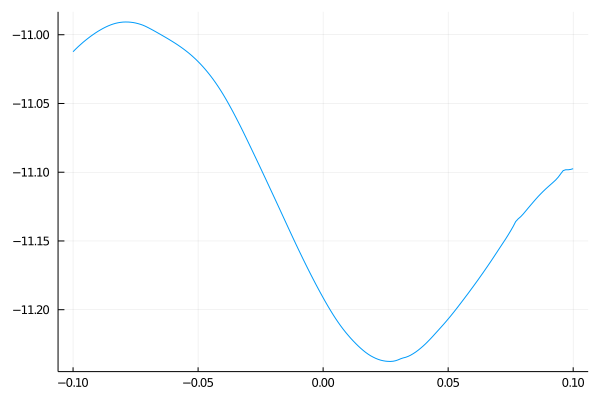

In [14]:
Plots.plot(range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1), evs[:,2], legend=false, fmt = :png)

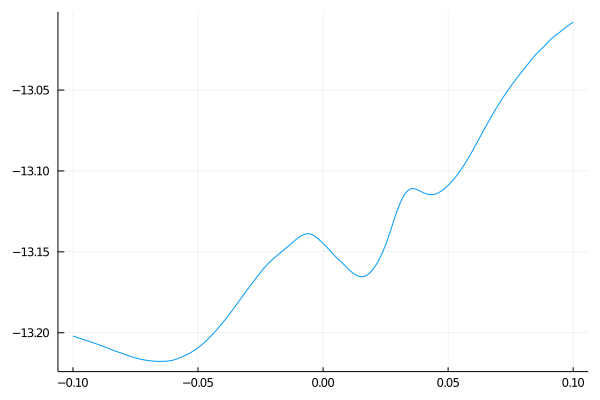

In [15]:
Plots.plot(range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1), evs[:,3], legend=false, fmt = :png)

In [16]:
[range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1)  evs]

201×7 Array{Float64,2}:
 -0.1    -10.4616  -11.0124  -13.202   -25.2169  -26.9275  -41.8009
 -0.099  -10.4611  -11.0105  -13.2026  -25.2157  -26.9277  -41.8015
 -0.098  -10.4607  -11.0088  -13.2031  -25.2146  -26.9279  -41.802
 -0.097  -10.4603  -11.0071  -13.2036  -25.2135  -26.9282  -41.8026
 -0.096  -10.46    -11.0055  -13.2041  -25.2124  -26.9284  -41.8032
 -0.095  -10.4597  -11.004   -13.2046  -25.2114  -26.9289  -41.8037
 -0.094  -10.4594  -11.0026  -13.2051  -25.2105  -26.9296  -41.8042
 -0.093  -10.4591  -11.0012  -13.2056  -25.2095  -26.9303  -41.8047
 -0.092  -10.4588  -10.9999  -13.2061  -25.2087  -26.9313  -41.8051
 -0.091  -10.4585  -10.9986  -13.2067  -25.2078  -26.9325  -41.8055
 -0.09   -10.4582  -10.9975  -13.2072  -25.207   -26.9338  -41.8058
 -0.089  -10.4579  -10.9964  -13.2078  -25.2062  -26.9355  -41.8063
 -0.088  -10.4576  -10.9954  -13.2084  -25.2054  -26.9373  -41.8066
  ⋮                                                ⋮       
  0.089  -10.4273  -11.1122  -13.

In [17]:
evs

201×6 Array{Float64,2}:
 -10.4616  -11.0124  -13.202   -25.2169  -26.9275  -41.8009
 -10.4611  -11.0105  -13.2026  -25.2157  -26.9277  -41.8015
 -10.4607  -11.0088  -13.2031  -25.2146  -26.9279  -41.802
 -10.4603  -11.0071  -13.2036  -25.2135  -26.9282  -41.8026
 -10.46    -11.0055  -13.2041  -25.2124  -26.9284  -41.8032
 -10.4597  -11.004   -13.2046  -25.2114  -26.9289  -41.8037
 -10.4594  -11.0026  -13.2051  -25.2105  -26.9296  -41.8042
 -10.4591  -11.0012  -13.2056  -25.2095  -26.9303  -41.8047
 -10.4588  -10.9999  -13.2061  -25.2087  -26.9313  -41.8051
 -10.4585  -10.9986  -13.2067  -25.2078  -26.9325  -41.8055
 -10.4582  -10.9975  -13.2072  -25.207   -26.9338  -41.8058
 -10.4579  -10.9964  -13.2078  -25.2062  -26.9355  -41.8063
 -10.4576  -10.9954  -13.2084  -25.2054  -26.9373  -41.8066
   ⋮                                                 ⋮
 -10.4273  -11.1122  -13.022   -25.0979  -27.0322  -42.0071
 -10.4268  -11.1105  -13.0202  -25.0986  -27.0347  -42.0073
 -10.4263  -11.1089  -

In [18]:
using DelimitedFiles

In [19]:
writedlm("D:/ocean_wind_"*string(grid_resolution)*"_"*string(Integer(num_steps/2)*ϵ)*"_"*string(t_end-t_initial)*".csv", [range(-(num_steps/2)*ϵ,(num_steps/2)*ϵ,length=num_steps+1)  evs], ",")